## Compare 3 resolution: 1/4-deg vs 1/10-deg vs 1/12-deg (linear), compare the scaling factor in the best tuned case

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import make_interp_spline
from scipy.interpolate import PchipInterpolator
import warnings
warnings.filterwarnings('ignore')

In [2]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')

# 8 major: M2, S2, N2, K1, O1, K2, P1, and Q1
amp_M2 = tpxo.ha.isel({'nc':0}).transpose()
amp_S2 = tpxo.ha.isel({'nc':1}).transpose()
amp_N2 = tpxo.ha.isel({'nc':2}).transpose()
amp_K2 = tpxo.ha.isel({'nc':3}).transpose()

amp_K1 = tpxo.ha.isel({'nc':4}).transpose()
amp_O1 = tpxo.ha.isel({'nc':5}).transpose()
amp_P1 = tpxo.ha.isel({'nc':6}).transpose()
amp_Q1 = tpxo.ha.isel({'nc':7}).transpose()

lon_tpxo = np.array(tpgd.lon_z.transpose())
lat_tpxo = np.array(tpgd.lat_z.transpose())
hz_tpxo  = np.array(tpgd.hz.transpose())
ny, nx   = tpgd.ny.size, tpgd.nx.size

In [3]:
mz = tpgd.mz.transpose() # land mask
land_mask = 1 - (mz*0).fillna(1)

In [4]:
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), hz_tpxo),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon_tpxo),
                              'lat': (('yh', 'xh'), lat_tpxo)})
land_tpxo = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [11]:
start_time = time.time()

Start plotting...
0
Plotting K1...
1
Plotting O1...
2
Plotting P1...
3
Plotting Q1...
Saving...


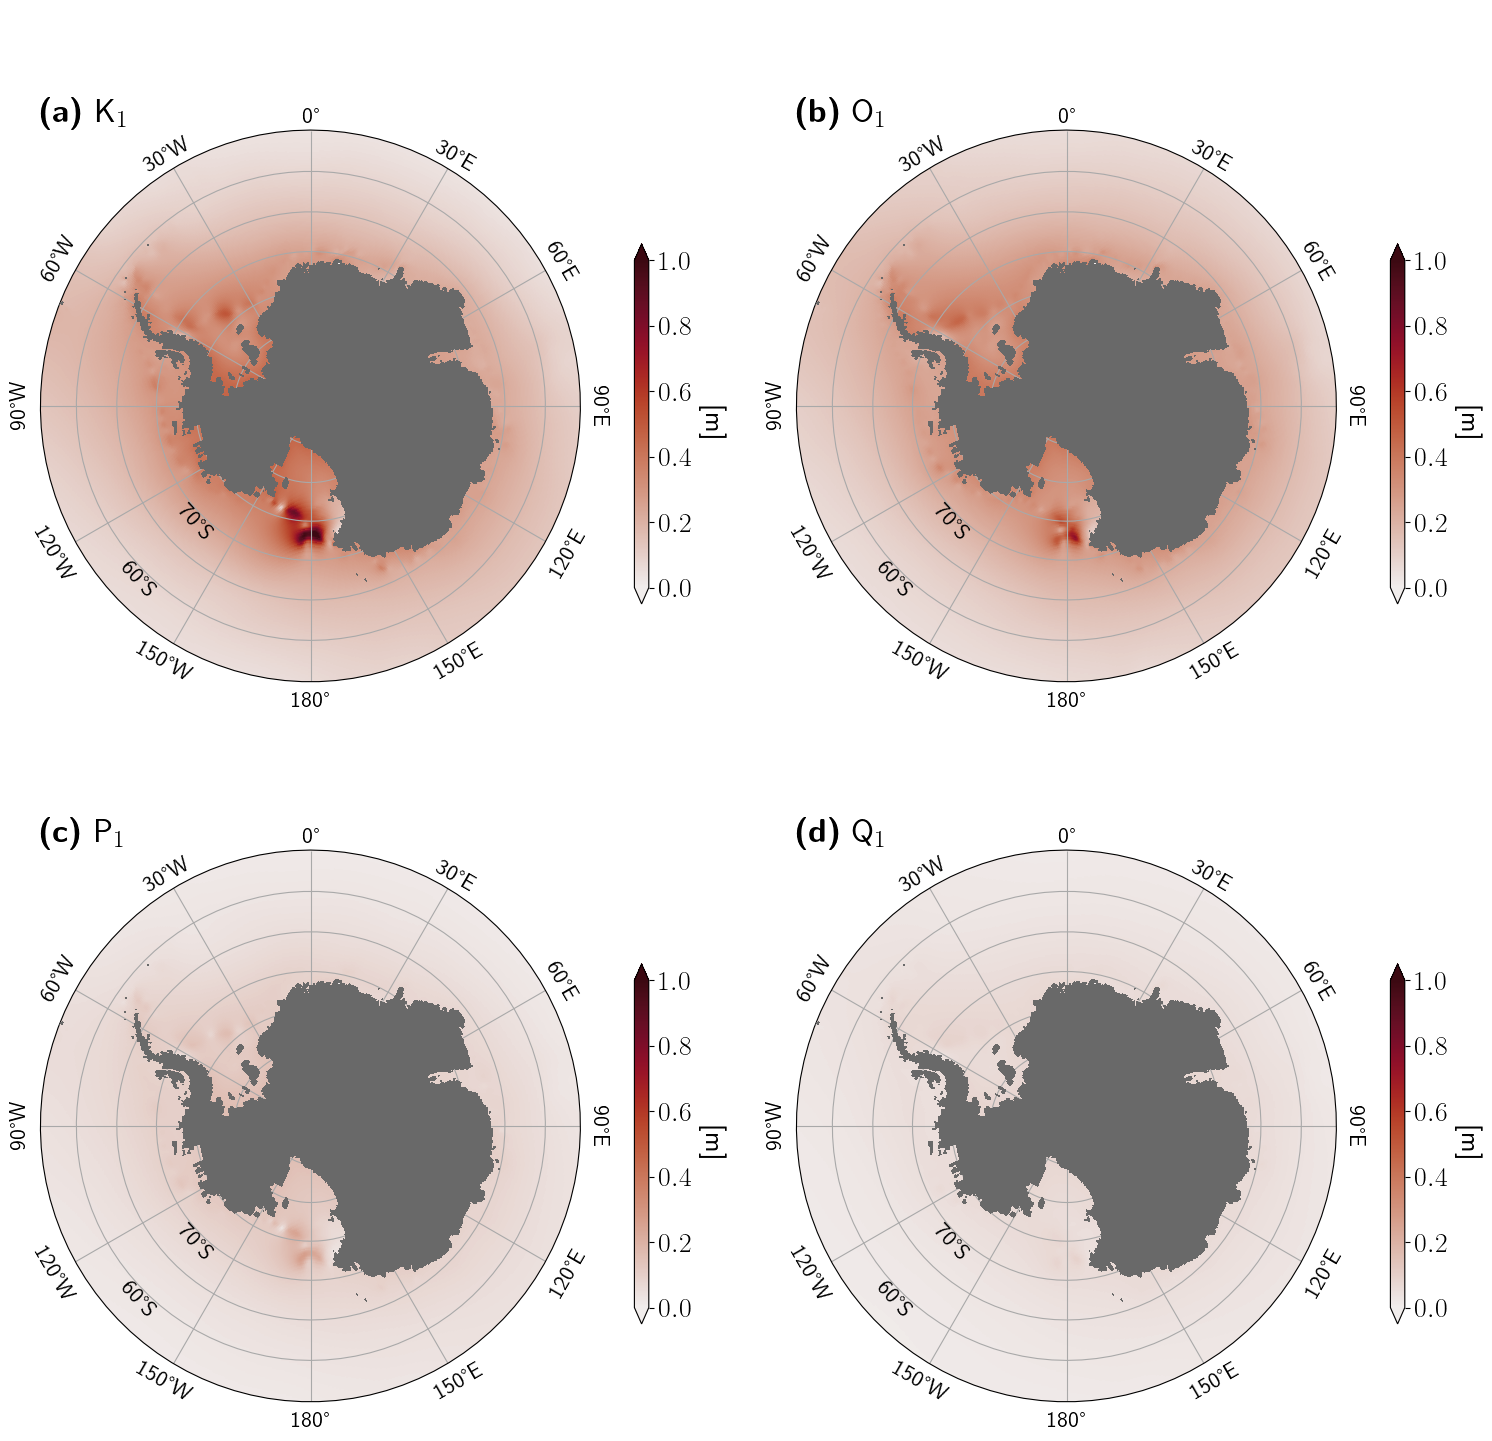

In [12]:
# Enable LaTeX text rendering
plt.rc('text', usetex=True)

fig = plt.figure(figsize=(18, 18))
axs = []

fontsize = 20
proj = ccrs.PlateCarree()
varlist = ['amp_K1', 'amp_O1', 'amp_P1', 'amp_Q1']
title   = [r'\textbf{(a)} K$_1$', r'\textbf{(b)} O$_1$', r'\textbf{(c)} P$_1$', r'\textbf{(d)} Q$_1$']

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

gridsubs = gridspec.GridSpec(2,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, (ax, var) in enumerate(zip(axs, varlist)):
    print(I)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    
    gl = ax.gridlines(draw_labels=False, color='darkgray')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
    label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
                 '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
    rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
    lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
                     -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
    for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                                  30, -150, 150, -30]):
        ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
                horizontalalignment='center', verticalalignment='center',
                color='k', fontsize=16, transform=proj)
    for j in range(60, 90, 10):
        label = str(j) + '°S'
        ax.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
                verticalalignment='center', color='k', fontsize=16,
                transform=proj)
    ax.set_extent([-180, 180, -90, -55], proj)
    ax.set_boundary(circle, transform=ax.transAxes)

    if I==0:
        print('Plotting K1...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        ax.set_position([0.1,0.5,0.3,0.32])
        ax_cb = plt.axes([0.43, 0.55, 0.008, 0.2])
        p1 = ax.pcolormesh(lon_tpxo, lat_tpxo, amp_K1, cmap=cm.cm.amp, transform=proj, vmin=0, vmax=1)
        cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left")


    if I==1:
        print('Plotting O1...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        ax.set_position([0.52,0.5,0.3,0.32])
        ax_cb = plt.axes([0.85, 0.55, 0.008, 0.2])
        p1 = ax.pcolormesh(lon_tpxo, lat_tpxo, amp_O1, cmap=cm.cm.amp, transform=proj, vmin=0, vmax=1)
        cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left")

    if I==2:
        print('Plotting P1...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        ax.set_position([0.1,0.1,0.3,0.32])
        ax_cb = plt.axes([0.43, 0.15, 0.008, 0.2])
        p1 = ax.pcolormesh(lon_tpxo, lat_tpxo, amp_P1, cmap=cm.cm.amp, transform=proj, vmin=0, vmax=1)
        cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left")

    if I==3:
        print('Plotting Q1...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        ax.set_position([0.52,0.1,0.3,0.32])
        ax_cb = plt.axes([0.85, 0.15, 0.008, 0.2])
        p1 = ax.pcolormesh(lon_tpxo, lat_tpxo, amp_Q1, cmap=cm.cm.amp, transform=proj, vmin=0, vmax=1)
        cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left")

print('Saving...')
plt.savefig('/g/data/nm03/lxy581/evaluate/tpxo9_amp/TPXO9_diurnal_amp_antarctica.png', dpi=300, bbox_inches='tight')        

In [13]:
end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f mins!" % (exe_time/60.0))

Execution time: 11.3 mins!
